# **GPT2 Trainer**
Code adapted from: https://huggingface.co/docs/transformers/tasks/language_modeling

In [1]:
!pip install transformers torch datasets evaluate numpy seaborn matplotlib
from transformers import AutoModelForMaskedLM
import torch
from datasets import load_dataset
import evaluate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
sns.set(context="poster")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 446.3 kB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
# Set the seed for reproducibility 
import random
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# from google.colab import files
# train_file = files.upload()
import sys
import os

from google.colab import drive
drive.mount("/content/drive")

dir_path = 'MyDrive/Colab Notebooks/LGEC'

env_path = f'/content/drive/{dir_path}'
print(os.listdir(env_path))

if env_path not in sys.path:
    sys.path.append(env_path)


Mounted at /content/drive
['model_outputs', 'Data', 'runs', 'Presentation', 'Emily', 'corrector.ipynb', 'BERT_trainer.ipynb', 'GPT_trainer.ipynb']


In [4]:
from transformers import AutoTokenizer, GPT2LMHeadModel

model_checkpoint = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
# model_checkpoint = f"{env_path}/model_outputs/checkpoint-5000/"
model = GPT2LMHeadModel.from_pretrained(model_checkpoint).to(device)
print(f"distilgpt2 number of parameters: {round(model.num_parameters() / 1_000_000, 2)}M")

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/353M [00:00<?, ?B/s]

distilgpt2 number of parameters: 81.91M


## **The Data**
TODO: Add more data exploration.

In [5]:
train_file = f"{env_path}/Data/all_train.txt"
print(f"Reading {train_file}...")
with open(train_file, "r") as f:
    train_text = f.read().split("\n")

val_file = f"{env_path}/Data/all_val.txt"
print(f"Reading {val_file}...")
with open(val_file, "r") as f:
    val_text = f.read().split("\n")

test_file = f"{env_path}/Data/all_test.txt"
print(f"Reading {test_file}...")
with open(test_file, "r") as f:
    test_text = f.read().split("\n")


# Where our model output gets saved after training
save_path = f"{env_path}/model_outputs/GPT_trained_state_dict_cased.pt"

Reading /content/drive/MyDrive/Colab Notebooks/LGEC/Data/all_train.txt...
Reading /content/drive/MyDrive/Colab Notebooks/LGEC/Data/all_val.txt...
Reading /content/drive/MyDrive/Colab Notebooks/LGEC/Data/all_test.txt...


In [6]:
# https://huggingface.co/docs/datasets/nlp_load
dataset = load_dataset("text", data_files={"train": train_file, "val": val_file, "test": test_file})
dataset

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset text downloaded and prepared to /root/.cache/huggingface/datasets/text/default-7292ef1cc9ebef0f/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 181632
    })
    val: Dataset({
        features: ['text'],
        num_rows: 24999
    })
    test: Dataset({
        features: ['text'],
        num_rows: 20409
    })
})

In [7]:
def tokenize_function(examples):
    result = tokenizer(examples["text"])
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    return result


tokenized_datasets = dataset.map(
    tokenize_function, batched=True, remove_columns=["text"]
)
tokenized_datasets

  0%|          | 0/182 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/21 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 181632
    })
    val: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 24999
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 20409
    })
})

In [8]:
chunk_size = 128
def group_texts(samples):
    # Concatenate all texts
    concatenated_samples = {k: sum(samples[k], []) for k in samples.keys()}
    # Compute length of concatenated texts
    total_length = len(concatenated_samples[list(samples.keys())[0]])
    # We drop the last chunk if it's smaller than chunk_size
    total_length = (total_length // chunk_size) * chunk_size
    # Split by chunks of max_len
    result = {
        k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_samples.items()
    }
    # Create a new labels column
    result["labels"] = result["input_ids"].copy()
    return result

In [9]:
lm_datasets = tokenized_datasets.map(group_texts, batched=True)
lm_datasets

  0%|          | 0/182 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/21 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 38160
    })
    val: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 5490
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 4044
    })
})

In [10]:
tokenizer.decode(lm_datasets["val"]["input_ids"][0])

'"It was further provided that in case there was damage to the sugars in transit to Philadelphia preventing seller from making full delivery, seller was to deliver to each purchaser of sugar aboard that steamer a proportionate part of the sound packages."The buyer\'s decision was to be given immediately upon advice of the seller that delay had occurred."In the event of such cancellation by the buyer, the seller was to be under no further obligation under the contract."The seller had on board the steamship West Cheswald sugars which before the end of September had been shipped on her from Java to New York."A radiogram was thereupon sent'

In [51]:
from transformers import DataCollatorForLanguageModeling
# What we use to mask over our training data
tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

## **Training**
**Note:** We finetune the already trained BERT model by further training with our legal text document data.

In [12]:
from transformers import TrainingArguments

# Model Hyperparams
batch_size = 50
num_epochs = 10
learning_rate = 2e-5
weight_decay = 0.01

logging_steps = 50 * num_epochs
training_args = TrainingArguments(
    num_train_epochs=num_epochs,
    output_dir=f"{env_path}/model_outputs/",
    save_steps=5000,
    overwrite_output_dir=True,
    evaluation_strategy="steps",
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    push_to_hub=False,
    fp16=True,
)

In [13]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["val"],
    data_collator=data_collator,
)

Using cuda_amp half precision backend


In [15]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: word_ids. If word_ids are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38160
  Num Epochs = 10
  Instantaneous batch size per device = 50
  Total train batch size (w. parallel, distributed & accumulation) = 50
  Gradient Accumulation steps = 1
  Total optimization steps = 7640
  Number of trainable parameters = 81912576
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the tex

Step,Training Loss,Validation Loss
500,3.979700,3.723639
1000,3.843100,3.673063
1500,3.786200,3.638531
2000,3.739700,3.621034
2500,3.708900,3.600970
3000,3.689300,3.588341
3500,3.666700,3.578855
4000,3.652000,3.569295
4500,3.638300,3.562296
5000,3.620800,3.556946


The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: word_ids. If word_ids are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5490
  Batch size = 50
The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: word_ids. If word_ids are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5490
  Batch size = 50
The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: word_ids. If word_ids are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5490
  Batch size = 50
The following columns in the evaluation set don't have a corresponding ar

TrainOutput(global_step=7640, training_loss=3.6878867703582605, metrics={'train_runtime': 3628.9702, 'train_samples_per_second': 105.154, 'train_steps_per_second': 2.105, 'total_flos': 1.24638550032384e+16, 'train_loss': 3.6878867703582605, 'epoch': 10.0})

In [16]:
# Plotting the training and validation loss.
# Note: This is quite a hacky way to do it but it works!
train_loss = []
val_loss = []
for idx, item in enumerate(trainer.state.log_history[:-1]):
    try:
        train_loss.append(item["loss"])
    except KeyError:
        try: 
            val_loss.append(item["eval_loss"])
        except KeyError:
            pass

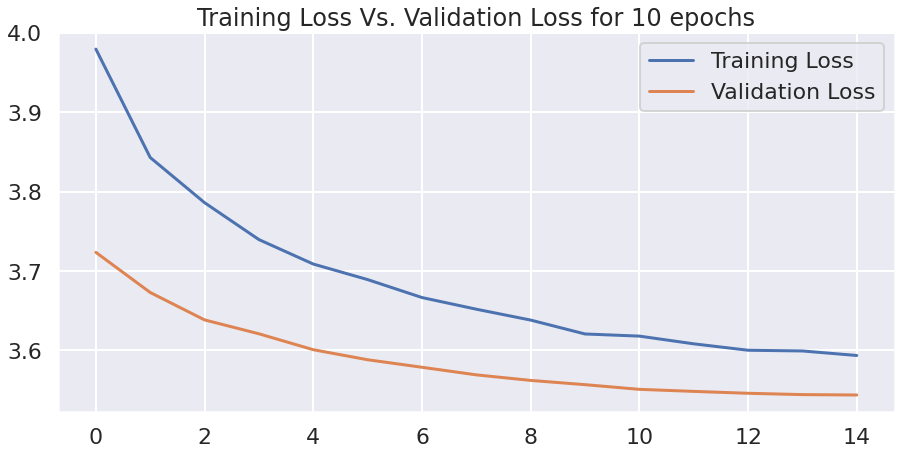

In [17]:
fig, ax = plt.subplots(figsize=(15, 7))
g = sns.lineplot(x=range(len(train_loss)), y=train_loss, ax=ax, label="Training Loss")
g = sns.lineplot(x=range(len(train_loss)), y=val_loss, ax=ax, label="Validation Loss")
plt.title(f"Training Loss Vs. Validation Loss for {num_epochs} epochs")
plt.show()

In [18]:
eval_results = trainer.evaluate()
print(f"Perplexity after fine-tuning: {math.exp(eval_results['eval_loss']):.2f}")

The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: word_ids. If word_ids are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5490
  Batch size = 50


Perplexity after fine-tuning: 34.60


In [19]:
save_path = f"{env_path}/model_outputs/GPT_trained_state_dict_cased.pt"
torch.save(model.state_dict(), save_path)

## **Evaluating Results** TODO
Metrics:
- Top 1 accuracy
- Top 3 accuracy
- Training loss Vs. Validation loss plot
- Perplexity

Evaluated on validation set, then once all hyperparams set, tested on test set.

In [15]:
from transformers import AutoTokenizer, DistilBertForMaskedLM, GPT2LMHeadModel 
# Load pre-trained GPT2 model
GPT_model_checkpoint = "distilgpt2"
GPT_tokenizer = AutoTokenizer.from_pretrained(GPT_model_checkpoint)
GPT_base_model = GPT2LMHeadModel.from_pretrained(GPT_model_checkpoint).to(device)
GPT_tuned_model = GPT2LMHeadModel.from_pretrained(GPT_model_checkpoint).to(device)
# Update pre-trained model with our learned weights
GPT_state_dict_path = f"{env_path}/model_outputs/GPT_trained_state_dict_cased.pt"
GPT_tuned_model.load_state_dict(torch.load(GPT_state_dict_path, map_location=torch.device(device)))

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilgpt2/snapshots/ee0b29d316a6a55fd15c50c4a97aca80ab4dd66a/config.json
Model config GPT2Config {
  "_name_or_path": "distilgpt2",
  "_num_labels": 1,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 6,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labe

<All keys matched successfully>

In [33]:
unk_token = GPT_tokenizer.vocab[GPT_tokenizer.unk_token]

def random_unk_mask(dataset):
  """Simulate the mlm data collator but for GPT2."""
  inputs = torch.tensor(dataset["input_ids"]).clone()
  num_choices = int(inputs.size(0) * inputs.size(1) * 0.15)
  y_idx = np.random.choice(inputs.size(0), num_choices)
  x_idx = np.random.choice(inputs.size(1), num_choices)
  # Set random indices to unknown
  inputs[y_idx, x_idx] = unk_token
  return {"input_ids": inputs}

In [46]:
softmax = torch.nn.Softmax(dim=2)

model = GPT_tuned_model
base_model = GPT_base_model
tokenizer = GPT_tokenizer

def get_num_correct(batch_inputs, batch_outputs, batch_labels, k):
    # NOTE: We have a slight issue in that the first word is not predicted,
    mask_idx = torch.where(batch_inputs == unk_token)
    # GPT2 model gives the score for the next word, in the idx before a word, so we
    # offset the index when calculating probabilities.
    prob_idx = tuple(idx - 1 for idx in mask_idx)
    for idx in mask_idx:
        idx = idx.to(device)
    # Get probability distribution over vocab for masked words
    prob = softmax(batch_outputs.logits)[prob_idx]
    y_true = batch_labels[mask_idx]
    p, y_pred = torch.topk(prob, dim=1, k=k)
    num_correct = torch.count_nonzero(torch.sum(torch.isin(y_pred, y_true), dim=1))
    total_num_masks = mask_idx[0].size(0)
    return num_correct, total_num_masks


def top_k_accuracy(model, dataset, k, batch_size=5):
    labels = torch.tensor(dataset["labels"]).to(device)
    inputs = random_unk_mask(dataset)["input_ids"]
    print(inputs.size())
    inputs = inputs.to(device)
    total_num_masks = 0
    total_num_correct = 0
    for i in range(0, inputs.size(0), batch_size):
        print("--------------------------------------------------")
        print(f"Calculating outputs: {i} / {inputs.size(0)}")
        batch_inputs = inputs[i:i+batch_size, :]
        batch_labels = labels[i:i+batch_size, :]
        with torch.no_grad():
            batch_outputs = model(batch_inputs)
        num_correct, total_batch_num_masks = get_num_correct(batch_inputs, batch_outputs, batch_labels, k)
        print(f"Num correct in k={k}: {num_correct} / {total_batch_num_masks}")
        print(f"Batch accuracy: {num_correct / total_batch_num_masks}")
        total_num_correct += num_correct
        total_num_masks += total_batch_num_masks
        print(f"Running Accuracy: {total_num_correct} / {total_num_masks} = {total_num_correct / total_num_masks}")

    return total_num_correct, total_num_masks

In [47]:
accuracy_dict = {"stock": {"val": {}, "test": {}}, "tuned": {"val": {}, "test": {}}}
model_dict = {"stock": base_model, "tuned": model}

model_name = "stock"
mode = "val"
for k in (1, 3):
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    print(f">>>>>>>>>>>>> MODE: {mode} | MODEL: {model_name} | k={k} >>>>>>>>>>>>>")
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    total_num_correct, total_num_masks = top_k_accuracy(base_model, lm_datasets[mode], k)
    accuracy = total_num_correct / total_num_masks
    accuracy_dict[model_name][mode][k] = accuracy

accuracy_dict

Streaming output truncated to the last 5000 lines.
--------------------------------------------------
Calculating outputs: 490 / 5490
Num correct in k=3: 86 / 102
Batch accuracy: 0.843137264251709
Running Accuracy: 6439 / 8853 = 0.7273240685462952
--------------------------------------------------
Calculating outputs: 495 / 5490
Num correct in k=3: 39 / 75
Batch accuracy: 0.5200000405311584
Running Accuracy: 6478 / 8928 = 0.7255824208259583
--------------------------------------------------
Calculating outputs: 500 / 5490
Num correct in k=3: 65 / 101
Batch accuracy: 0.6435643434524536
Running Accuracy: 6543 / 9029 = 0.7246649265289307
--------------------------------------------------
Calculating outputs: 505 / 5490
Num correct in k=3: 64 / 100
Batch accuracy: 0.6399999856948853
Running Accuracy: 6607 / 9129 = 0.7237375378608704
--------------------------------------------------
Calculating outputs: 510 / 5490
Num correct in k=3: 87 / 104
Batch accuracy: 0.8365384936332703
Running Accu

{'stock': {'val': {1: tensor(0.5352, device='cuda:0'),
   3: tensor(0.7064, device='cuda:0')},
  'test': {}},
 'tuned': {'val': {}, 'test': {}}}

In [48]:
model_name = "tuned"
mode = "val"
for k in (1, 3):
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    print(f">>>>>>>>>>>>> MODE: {mode} | MODEL: {model_name} | k={k} >>>>>>>>>>>>>")
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    total_num_correct, total_num_masks = top_k_accuracy(model, lm_datasets[mode], k)
    accuracy = total_num_correct / total_num_masks
    accuracy_dict[model_name][mode][k] = accuracy

accuracy_dict

Streaming output truncated to the last 5000 lines.
--------------------------------------------------
Calculating outputs: 490 / 5490
Num correct in k=3: 62 / 79
Batch accuracy: 0.7848101258277893
Running Accuracy: 7149 / 8887 = 0.8044334650039673
--------------------------------------------------
Calculating outputs: 495 / 5490
Num correct in k=3: 66 / 83
Batch accuracy: 0.7951806783676147
Running Accuracy: 7215 / 8970 = 0.804347813129425
--------------------------------------------------
Calculating outputs: 500 / 5490
Num correct in k=3: 69 / 86
Batch accuracy: 0.8023256063461304
Running Accuracy: 7284 / 9056 = 0.8043286204338074
--------------------------------------------------
Calculating outputs: 505 / 5490
Num correct in k=3: 70 / 88
Batch accuracy: 0.7954545617103577
Running Accuracy: 7354 / 9144 = 0.8042432069778442
--------------------------------------------------
Calculating outputs: 510 / 5490
Num correct in k=3: 85 / 104
Batch accuracy: 0.817307710647583
Running Accuracy

{'stock': {'val': {1: tensor(0.5352, device='cuda:0'),
   3: tensor(0.7064, device='cuda:0')},
  'test': {}},
 'tuned': {'val': {1: tensor(0.5742, device='cuda:0'),
   3: tensor(0.7915, device='cuda:0')},
  'test': {}}}

### Accuracy Results


```'stock': {'val': {1: 0.5352, 3: 0.7064}, 'tuned': {'val': {1: 0.5742, 3: 0.7915}```


## Perplexity

In [52]:
from transformers import TrainingArguments
from transformers import Trainer
import math

def get_perplexity(model, eval_dataset):
    # Model Hyperparams
    batch_size = 50
    num_epochs = 30
    learning_rate = 2e-5
    weight_decay = 0.01
    logging_steps = 50 * num_epochs
    training_args = TrainingArguments(
        num_train_epochs=num_epochs,
        output_dir=f"{env_path}",
        overwrite_output_dir=False,
        evaluation_strategy="steps",
        logging_steps=logging_steps,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        push_to_hub=False,
        fp16=True,
    )
    eval_trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=lm_datasets["train"],
        eval_dataset=eval_dataset,
        data_collator=data_collator,
    )
    eval_results = eval_trainer.evaluate()
    return math.exp(eval_results['eval_loss'])

In [53]:
print("--------------------------------------------------")
print(f"Perplexity for the base model, evaluated on the validation set: {get_perplexity(base_model, lm_datasets['val'])}")
print(f"Perplexity for our fine-tuned model, evaluated on the validation set: {get_perplexity(model, lm_datasets['val'])}")

# print("--------------------------------------------------")
# print(f"Perplexity for the base model, evaluated on the test set: {get_perplexity(base_model, lm_datasets['test'])}")
# print(f"Perplexity for our fine-tuned model, evaluated on the test set: {get_perplexity(model, lm_datasets['test'])}")

using `logging_steps` to initialize `eval_steps` to 1500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: word_ids. If word_ids are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5490
  Batch size = 50
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


--------------------------------------------------


using `logging_steps` to initialize `eval_steps` to 1500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: word_ids. If word_ids are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5490
  Batch size = 50


Perplexity for the base model, evaluated on the validation set: 67.9424693619588


Perplexity for our fine-tuned model, evaluated on the validation set: 34.6022218169037


### Perplexity Results
Perplexity for the base model, evaluated on the validation set: 67.9424693619588 

Perplexity for our fine-tuned model, evaluated on the validation set: 34.6022218169037

## Uploading Model to Huggingface Hub

In [55]:
!pip install huggingface_hub
from huggingface_hub import notebook_login

notebook_login()

model.push_to_hub("distilgpt2-for-legal-grammar-error-correction")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Configuration saved in /tmp/tmp7usihpj4/config.json
Model weights saved in /tmp/tmp7usihpj4/pytorch_model.bin
Uploading the following files to isaacjeffersonlee/distilgpt2-for-legal-grammar-error-correction: pytorch_model.bin,config.json


CommitInfo(commit_url='https://huggingface.co/isaacjeffersonlee/distilgpt2-for-legal-grammar-error-correction/commit/12d053f7e93dbe832e0e512b267fb02d9c0bef93', commit_message='Upload model', commit_description='', oid='12d053f7e93dbe832e0e512b267fb02d9c0bef93', pr_url=None, pr_revision=None, pr_num=None)